# Supervised Learning: Random Forest

In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn.metrics as metrics
from sklearn.metrics import recall_score, make_scorer, roc_auc_score

from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import cross_val_predict, cross_val_score, train_test_split, KFold, RandomizedSearchCV, GridSearchCV

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os

BASE_FOLDER="/content/drive/MyDrive/Master-VIU/09MIAR_TFM/Tumor-Educated_Platelets/data/"
PROYECTO="IntVeld2022"
PROYECT_FOLDER = os.path.join(BASE_FOLDER,PROYECTO)

## Read File


In [4]:
# Read dataFrame
file='DataPatients_train.csv'
df_train = pd.read_csv(os.path.join(PROYECT_FOLDER,file), sep=';',index_col=0, na_values='n.a.', dtype={'Stage': 'object', 'Age': 'float64'})

file='DataPatients_test.csv'
df_test = pd.read_csv(os.path.join(PROYECT_FOLDER,file), sep=';',index_col=0, na_values='n.a.', dtype={'Stage': 'object', 'Age': 'float64'})

## Remove some columns, numeric labels and Split X and Y

In [5]:
# Split X and Y
# Choose which label to use for ground truth (in this case class)

columns = df_train.columns    # 'ENSGxxxx' ... 'Sample ID', 'Stage', 'Sex', 'Age', 'Sample-supplying institution',
#                         'Training series', 'Evaluation series', 'Validation series',
#                         'Class_group', 'Patient_group'],
X_train = df_train[columns[0:-10]]
y_train_c = df_train[columns[-2]]

X_test = df_test[columns[0:-10]]
y_test_c= df_test[columns[-2]]

unique, counts = np.unique(y_train_c, return_counts=True)
print("Train")
print(unique)
print(counts)
print("Test")
unique, counts = np.unique(y_test_c, return_counts=True)
print(unique)
print(counts)

y_train = y_train_c.apply(lambda x: 1 if x == 'Malignant' else 0)
y_test = y_test_c.apply(lambda x: 1 if x == 'Malignant' else 0)

Train
['Malignant' 'nonMalignant']
[1313  566]
Test
['Malignant' 'nonMalignant']
[313 157]


Decissions taken:
* Variables: only genes (for the moment, not use sex, age, stage etc.)
* Ground truth: class_patient 
* Train with all nonMalignant (assymptomatics and symptomatics)

## RF (Random Forest), 2881 genes, all patients

### Get the best estimator from the grid search (ran using only training data)

In [8]:
import multiprocessing
n_cpus = multiprocessing.cpu_count()
print(n_cpus)

2


In [ ]:
# https://www.analyticsvidhya.com/blog/2020/05/decision-tree-vs-random-forest-algorithm/
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

In [9]:
# https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

params = {'bootstrap': [True, False], # Whether bootstrap samples are used when building trees. If False, the whole dataset is used to build each tree.
          'max_depth': [100, 300, 500, None], # The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.
          'n_estimators': [200, 400, 600, 800, 1000] # The number of trees in the forest.
          }

random_search_spe = RandomizedSearchCV(estimator = RandomForestClassifier(), param_distributions = params, random_state = 42, scoring = make_scorer(recall_score,pos_label=0), n_jobs=n_cpus, n_iter = 10, verbose=2)
random_search_spe.fit(X_train, y_train)

# Extract best parameters and best metric
print("Best params: ", random_search_spe.best_params_)
print("Best score: ", random_search_spe.best_score_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best params:  {'n_estimators': 400, 'max_depth': 300, 'bootstrap': False}
Best score:  0.4345909020338457


In [10]:
results = pd.DataFrame(random_search_spe.cv_results_)
columns_r = list(results.columns)
# print(columns_r)
columns_r = columns_r[:5] + columns_r[8:-3] + columns_r[-2:-2]
results.drop(columns=columns_r, inplace = True)
results

,param_max_depth,param_bootstrap,params,mean_test_score,std_test_score,rank_test_score
0,None,True,"{'n_estimators': 1000, 'max_depth': None, 'boo...",0.381633,0.060159,10
1,None,True,"{'n_estimators': 400, 'max_depth': None, 'boot...",0.392299,0.062122,5
2,None,True,"{'n_estimators': 200, 'max_depth': None, 'boot...",0.392206,0.059238,6
3,300,False,"{'n_estimators': 400, 'max_depth': 300, 'boots...",0.434591,0.062377,1
4,100,True,"{'n_estimators': 1000, 'max_depth': 100, 'boot...",0.383434,0.053542,9
5,500,True,"{'n_estimators': 600, 'max_depth': 500, 'boots...",0.388713,0.070449,7
6,None,False,"{'n_estimators': 600, 'max_depth': None, 'boot...",0.427589,0.050137,3
7,300,False,"{'n_estimators': 600, 'max_depth': 300, 'boots...",0.427511,0.061066,4
8,None,False,"{'n_estimators': 1000, 'max_depth': None, 'boo...",0.431098,0.063910,2
9,300,True,"{'n_estimators': 400, 'max_depth': 300, 'boots...",0.386974,0.066332,8


### Train the best estimator with training data and test it in test data


In [12]:
# Once hyperparameters have been optimized, the final model is trained and tested
model = random_search_spe.best_estimator_

model.fit(X_train, y_train)   # entrenamiento completo

y_pred = model.predict(X_test)
test_results = model.score(X_test, y_test) 
print('Test accuracy: ', np.round(test_results*100,4), '%')

Test accuracy:  76.1702 %


In [13]:
print("Tabla de métricas:\n", metrics.classification_report(y_test, y_pred))


Tabla de métricas:
               precision    recall  f1-score   support

           0       0.79      0.39      0.52       157
           1       0.76      0.95      0.84       313

    accuracy                           0.76       470
   macro avg       0.77      0.67      0.68       470
weighted avg       0.77      0.76      0.73       470



In [14]:
print(metrics.confusion_matrix(y_test, y_pred))

[[ 61  96]
 [ 16 297]]


In [15]:
auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
print(auc)

0.8453633422193281


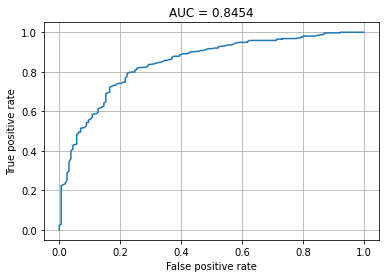

In [16]:
# Plot ROC curve
y_proba_test = model.predict_proba(X_test)
fpr, tpr, th = metrics.roc_curve(y_test, y_proba_test[:,1])

plt.plot(fpr, tpr)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('AUC = ' + str(np.round(auc,4)))
plt.grid()
plt.show()

## RF: 2881 genes,  removing symptomatics from healthy

Article: Symptomatic controls were not included in the training and evaluation series because of their overrepresented prevalence as opposed to the asymptomatic controls, compared with a real-world setting.

In [17]:
print(df_train.shape, df_test.shape)

(1879, 2891) (470, 2891)


In [18]:
# Remove symptomatic nonMalignant cases
df_train_new = df_train.drop(df_train[(df_train['Class_group'] == 'nonMalignant') & (df_train['Patient_group'] != 'Asymptomatic controls')].index)
df_test_new = df_test.drop(df_test[(df_test['Class_group'] == 'nonMalignant') & (df_test['Patient_group'] != 'Asymptomatic controls')].index)

In [19]:
print(df_train_new.shape, df_test_new.shape)

(1619, 2891) (397, 2891)


In [20]:
columns = df_train_new.columns    # 'ENSGxxxx' ... 'Sample ID', 'Stage', 'Sex', 'Age', 'Sample-supplying institution',
#                         'Training series', 'Evaluation series', 'Validation series',
#                         'Class_group', 'Patient_group'],
X_train = df_train_new[columns[0:-10]]
y_train_c = df_train_new[columns[-2]]

X_test = df_test_new[columns[0:-10]]
y_test_c= df_test_new[columns[-2]]

unique, counts = np.unique(y_train_c, return_counts=True)
print("Train")
print(unique)
print(counts)
print("Test")
unique, counts = np.unique(y_test_c, return_counts=True)
print(unique)
print(counts)
y_train = y_train_c.apply(lambda x: 1 if x == 'Malignant' else 0)
y_test = y_test_c.apply(lambda x: 1 if x == 'Malignant' else 0)

Train
['Malignant' 'nonMalignant']
[1313  306]
Test
['Malignant' 'nonMalignant']
[313  84]


### Metric: Specificity

#### Find best hyperparameters

In [22]:
params = {'bootstrap': [True, False], # Whether bootstrap samples are used when building trees. If False, the whole dataset is used to build each tree.
          'max_depth': [100, 300, 500, None], # The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.
          'n_estimators': [200, 400, 600, 800, 1000] # The number of trees in the forest.
          }

random_search_spe = RandomizedSearchCV(estimator = RandomForestClassifier(), param_distributions = params, random_state = 42, scoring = make_scorer(recall_score,pos_label=0), n_jobs=n_cpus, n_iter = 10, verbose=2)
random_search_spe.fit(X_train, y_train)

# Extract best parameters and best metric
print("Best params: ", random_search_spe.best_params_)
print("Best score: ", random_search_spe.best_score_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best params:  {'n_estimators': 400, 'max_depth': 300, 'bootstrap': False}
Best score:  0.26129032258064516


In [23]:
results = pd.DataFrame(random_search_spe.cv_results_)
columns_r = list(results.columns)
# print(columns_r)
columns_r = columns_r[:5] + columns_r[8:-3] + columns_r[-2:-2]
results.drop(columns=columns_r, inplace = True)
results

,param_max_depth,param_bootstrap,params,mean_test_score,std_test_score,rank_test_score
0,None,True,"{'n_estimators': 1000, 'max_depth': None, 'boo...",0.192597,0.040612,9
1,None,True,"{'n_estimators': 400, 'max_depth': None, 'boot...",0.189371,0.028958,10
2,None,True,"{'n_estimators': 200, 'max_depth': None, 'boot...",0.192755,0.018448,7
3,300,False,"{'n_estimators': 400, 'max_depth': 300, 'boots...",0.261290,0.031308,1
4,100,True,"{'n_estimators': 1000, 'max_depth': 100, 'boot...",0.202433,0.030577,6
5,500,True,"{'n_estimators': 600, 'max_depth': 500, 'boots...",0.192649,0.030492,8
6,None,False,"{'n_estimators': 600, 'max_depth': None, 'boot...",0.248228,0.032159,2
7,300,False,"{'n_estimators': 600, 'max_depth': 300, 'boots...",0.238392,0.032202,3
8,None,False,"{'n_estimators': 1000, 'max_depth': None, 'boo...",0.238340,0.041846,4
9,300,True,"{'n_estimators': 400, 'max_depth': 300, 'boots...",0.202485,0.023171,5


#### Train model and test it

In [24]:
# Once hyperparameters have been optimized, the final model is trained and tested
model = random_search_spe.best_estimator_

model.fit(X_train, y_train)   # entrenamiento completo

y_pred = model.predict(X_test)
test_results = model.score(X_test, y_test) 
print('Test accuracy: ', np.round(test_results*100,4), '%')

Test accuracy:  82.6196 %


In [25]:
print("Tabla de métricas:\n", metrics.classification_report(y_test, y_pred))


Tabla de métricas:
               precision    recall  f1-score   support

           0       0.76      0.26      0.39        84
           1       0.83      0.98      0.90       313

    accuracy                           0.83       397
   macro avg       0.80      0.62      0.64       397
weighted avg       0.82      0.83      0.79       397



In [26]:
print(metrics.confusion_matrix(y_test, y_pred))

[[ 22  62]
 [  7 306]]


In [27]:
auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
print(auc)

0.884185303514377


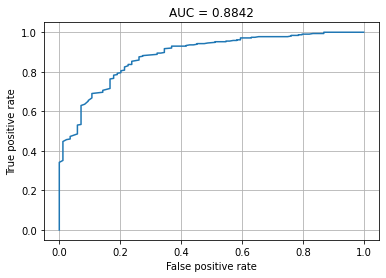

In [28]:
# Plot ROC curve
y_proba_test = model.predict_proba(X_test)
fpr, tpr, th = metrics.roc_curve(y_test, y_proba_test[:,1])

plt.plot(fpr, tpr)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('AUC = ' + str(np.round(auc,4)))
plt.grid()
plt.show()

### Trying another metric: roc aux score

Not balanced classes. Let's use another metric

#### Find best hyperparameters

In [37]:
params = {'bootstrap': [True, False], # Whether bootstrap samples are used when building trees. If False, the whole dataset is used to build each tree.
          'max_depth': [100, 300, 500, None], # The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.
          'n_estimators': [200, 400, 600, 800, 1000] # The number of trees in the forest.
          }

random_search_spe = RandomizedSearchCV(estimator = RandomForestClassifier(), param_distributions = params, random_state = 42, scoring = 'roc_auc', n_jobs=n_cpus, n_iter = 10, verbose=2)
random_search_spe.fit(X_train, y_train)

# Extract best parameters and best metric
print("Best params: ", random_search_spe.best_params_)
print("Best score: ", random_search_spe.best_score_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best params:  {'n_estimators': 600, 'max_depth': 300, 'bootstrap': False}
Best score:  0.8993769760267678


In [38]:
results = pd.DataFrame(random_search_spe.cv_results_)
columns_r = list(results.columns)
# print(columns_r)
columns_r = columns_r[:5] + columns_r[8:-3] + columns_r[-2:-2]
results.drop(columns=columns_r, inplace = True)
results

,param_max_depth,param_bootstrap,params,mean_test_score,std_test_score,rank_test_score
0,None,True,"{'n_estimators': 1000, 'max_depth': None, 'boo...",0.885143,0.017537,5
1,None,True,"{'n_estimators': 400, 'max_depth': None, 'boot...",0.884088,0.019968,6
2,None,True,"{'n_estimators': 200, 'max_depth': None, 'boot...",0.875268,0.014878,10
3,300,False,"{'n_estimators': 400, 'max_depth': 300, 'boots...",0.896391,0.010778,4
4,100,True,"{'n_estimators': 1000, 'max_depth': 100, 'boot...",0.884047,0.016080,7
5,500,True,"{'n_estimators': 600, 'max_depth': 500, 'boots...",0.882449,0.017749,9
6,None,False,"{'n_estimators': 600, 'max_depth': None, 'boot...",0.899270,0.015403,2
7,300,False,"{'n_estimators': 600, 'max_depth': 300, 'boots...",0.899377,0.014044,1
8,None,False,"{'n_estimators': 1000, 'max_depth': None, 'boo...",0.898098,0.016254,3
9,300,True,"{'n_estimators': 400, 'max_depth': 300, 'boots...",0.882792,0.020210,8


#### Train model and test it

In [39]:
# Once hyperparameters have been optimized, the final model is trained and tested
model = random_search_spe.best_estimator_

model.fit(X_train, y_train)   # entrenamiento completo

y_pred = model.predict(X_test)
test_results = model.score(X_test, y_test) 
print('Test accuracy: ', np.round(test_results*100,4), '%')

Test accuracy:  82.3678 %


In [40]:
print("Tabla de métricas:\n", metrics.classification_report(y_test, y_pred))


Tabla de métricas:
               precision    recall  f1-score   support

           0       0.77      0.24      0.36        84
           1       0.83      0.98      0.90       313

    accuracy                           0.82       397
   macro avg       0.80      0.61      0.63       397
weighted avg       0.82      0.82      0.78       397



In [41]:
print(metrics.confusion_matrix(y_test, y_pred))

[[ 20  64]
 [  6 307]]


In [43]:
auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
print(auc)

0.8866195040316446


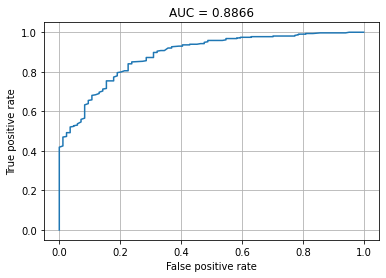

In [44]:
# Plot ROC curve
y_proba_test = model.predict_proba(X_test)
fpr, tpr, th = metrics.roc_curve(y_test, y_proba_test[:,1])

plt.plot(fpr, tpr)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('AUC = ' + str(np.round(auc,4)))
plt.grid()
plt.show()